# Load Data and Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

df_calendar_bos = pd.read_csv('./boston/calendar.csv')

df_calendar_sea = pd.read_csv('./seattle/calendar.csv')

In this section, I will analysis the prices difference between the Boston Airbnb and Seattle Airbnb in certain time frames.

In [3]:
df_calendar_bos.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [4]:
df_calendar_sea.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


# Clean and reformat data

In [5]:
def reformat_data(df):
    # Convert price string into float
    df.price = df.price.str.replace("[$, ]", "").astype("float")
    # Change date to datetime
    df["date"] = pd.to_datetime(df["date"])
    # Set the index to date and extract year, month, day, dayofweek
    df = df.set_index("date")
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day"] = df.index.day
    df["dow"] = df.index.dayofweek
    # Convert "t" available into 1, "f" into 0
    df["available"]=df["available"].apply(lambda x:1 if x=="t" else 0)
    return df


In [6]:
df_cal_bos = reformat_data(df_calendar_bos).reset_index()
df_cal_sea = reformat_data(df_calendar_sea).reset_index()

In [7]:
df_cal_bos

,date,listing_id,available,price,year,month,day,dow
0,2017-09-05,12147973,0,NaN,2017,9,5,1
1,2017-09-04,12147973,0,NaN,2017,9,4,0
2,2017-09-03,12147973,0,NaN,2017,9,3,6
3,2017-09-02,12147973,0,NaN,2017,9,2,5
4,2017-09-01,12147973,0,NaN,2017,9,1,4
...,...,...,...,...,...,...,...,...
1308885,2016-09-10,14504422,0,NaN,2016,9,10,5
1308886,2016-09-09,14504422,0,NaN,2016,9,9,4
1308887,2016-09-08,14504422,0,NaN,2016,9,8,3
1308888,2016-09-07,14504422,0,NaN,2016,9,7,2


In [9]:
weekly_trend_bos = df_cal_bos.groupby(['dow']).count()
weekly_trend_sea = df_cal_sea.groupby(['dow']).count()

In [10]:
weekly_trend_bos

,date,listing_id,available,price,year,month,day
dow,,,,,,,
0,186472,186472,186472,92413,186472,186472,186472
1,190058,190058,190058,93332,190058,190058,190058
2,186472,186472,186472,91816,186472,186472,186472
3,186472,186472,186472,91202,186472,186472,186472
4,186472,186472,186472,90998,186472,186472,186472
5,186472,186472,186472,91068,186472,186472,186472
6,186472,186472,186472,92208,186472,186472,186472


In [19]:
availabltiy_bos = weekly_trend_bos.price / weekly_trend_bos.listing_id
availabltiy_sea = weekly_trend_sea.price / weekly_trend_sea.listing_id

[Text(0, 0, 'Monday'),
 Text(1, 0, 'Tuesday'),
 Text(2, 0, 'Wednesday'),
 Text(3, 0, 'Thursday'),
 Text(4, 0, 'Friday'),
 Text(5, 0, 'Saturday'),
 Text(6, 0, 'Sunday')]

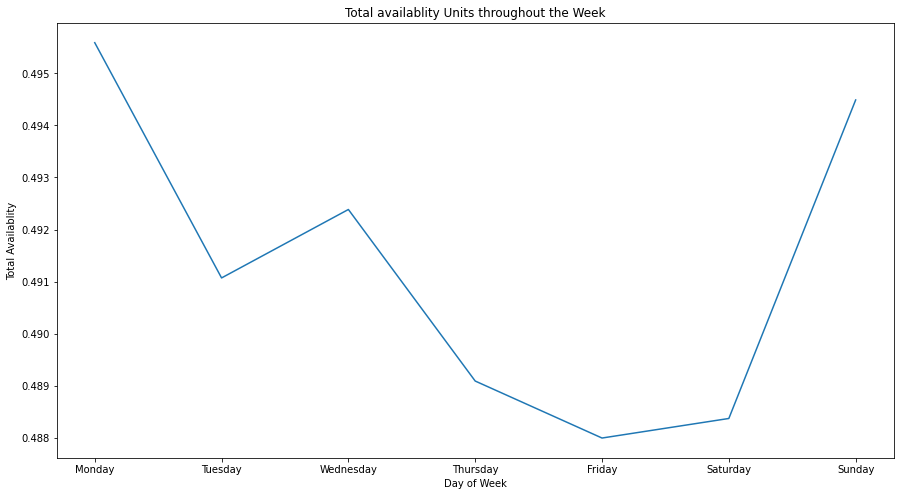

In [26]:
plt.figure(figsize=(15,8))

ax = sns.lineplot(data = availabltiy_bos)
ax.set(xlabel="Day of Week",ylabel="Total Availablity", title="Total availablity throughout the week in Boston")
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

[Text(0, 0, 'Monday'),
 Text(1, 0, 'Tuesday'),
 Text(2, 0, 'Wednesday'),
 Text(3, 0, 'Thursday'),
 Text(4, 0, 'Friday'),
 Text(5, 0, 'Saturday'),
 Text(6, 0, 'Sunday')]

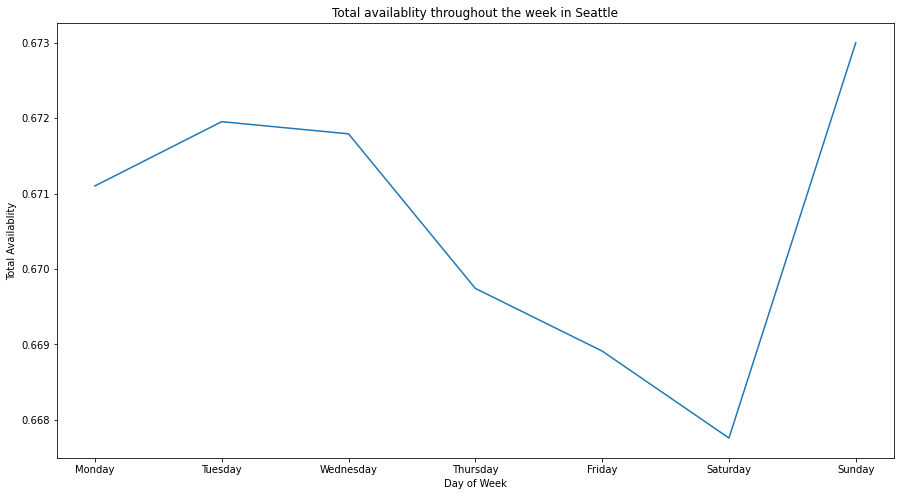

In [32]:
plt.figure(figsize=(15,8))

ax = sns.lineplot(data = availabltiy_sea)
ax.set(xlabel="Day of Week",ylabel="Total Availablity", title="Total availablity throughout the week in Seattle")
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

In [ ]:
weekly_availablity = pd.concat([availabltiy_bos.rename('boston availablity'), availabltiy_sea.rename('seattle availablity')], axis=1)